In [1]:
import jax.numpy as jnp
import optimistix as optx

In [2]:
# jax.config.update("jax_enable_x64", True)


# # TODO: which problem is this? ZECEVIC?
# def objective(x, args):
#     num_vars = x.size
#     fractions = 2 * jnp.arange(1, num_vars + 1) / num_vars
#     return jnp.sum((x - fractions) ** 2)


# def constraint(x):
#     return jnp.sum(x) - 1, x[0] + 10000   # Dummy inequality constraint: x > -10000


# x0 = jr.normal(jr.key(0), (10,))
# x0 = jnp.abs(x0)
# x0 = x0 / jnp.sum(x0)
# Note: I seem to have a bug that I get when the starting value is
# [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# This one seems to be about NaN / inf input, so its likely a problem in the descent
# formulation

# I also identified another bug - it looks like feasibility restoration gets called even
# though we're inside the bounds and the constraint is satisfied. Then it returns the
# same value, which triggers another call to the feasibility restoration. I don't know
# why it gets called from there in the first place? But this should not happen, this is
# not the purpose of the feasibility restoration, and it can't work with the way it is
# formulated.
# I think this could be because I don't yet adapt the barrier parameters? If I then use
# a tolerance that is smaller than the barrier parameter, then it has an impossible task
# and that could be the cause of the doom loop.

# bounds = jnp.full_like(x0, 0.0), jnp.full_like(x0, jnp.inf)

# solver = optx.IPOPTLike(rtol=1e-3, atol=1e-3)

# sol = optx.minimise(objective, solver, x0, constraint=constraint, bounds=bounds)

# sol.stats["num_steps"]

In [3]:
# import matplotlib.pyplot as plt


# x = jnp.ones(10)
# n = x.size

# y = (x - jnp.arange(1, n + 1) / n) ** 2

# plt.plot(jnp.arange(n), y)

In [4]:
# # BIGGSC4
# # https://doi.org/10.1016/0165-1889(94)90075-2, page 190
# def objective(y, args):
#     del args
#     x1, x2, x3, x4 = y
#     return -x1 * x3 - x2 * x4


# def constraint(y):
#     x1, x2, x3, x4 = y
#     cl1 = x1 + x2
#     cu1 = 5 - x1 + x2
#     cl2 = x1 + x3
#     cu2 = 5 - x1 + x3
#     cl3 = x1 + x4
#     cu3 = 5 - x1 + x4
#     cl4 = x2 + x3
#     cu4 = 4.5 - x2 + x3
#     cl5 = x2 + x4 - 0.5
#     cu5 = 4.5 - x2 + x4
#     cl6 = x3 + x4 - 1
#     cu6 = 4 - x3 + x4
#     cl7 = x1 + x2 + x3 + x4 - 5
#     constraints = [cl1, cu1, cl2, cu2, cl3, cu3, cl4, cu4, cl5, cu5, cl6, cu6, cl7]
#     return None, jnp.asarray(constraints)


# # Bounds
# bounds = jnp.full_like(x0, 0.0), jnp.full_like(x0, 5.0)

# # Initial guess
# x0 = jnp.ones(4)

# # Expected solution according to the SIF collection:
# expected_results = -24.5  # TODO: is this the objective value?

# solver = optx.InteriorPoint(rtol=1e-3, atol=1e-6)

# sol = optx.quadratic_solve(objective, solver, jnp.ones(4), constraint=constraint)
# sol.value, objective(sol.value, None)

In [5]:
# BIGGSB1
# https://doi.org/10.1016/0165-1889(94)90075-2, page 188 (I think)
# Looks like Example 1 but I'm not sure that is correct given the SIF file? The latter
# only mentions an object lower bound, but that appears to be the lower bound on the
# variables.


def objective(y, args):
    del args

    value = (y[0] - 1) ** 2
    for i in range(1, y.size - 1):
        value += (y[i] - y[i - 1]) ** 2
    value += (y[-1] - 1) ** 2

    return value


def constraint(y):  # dummy constraint
    return jnp.array(0.0), jnp.array(0.0)


# Initial value
x0 = 0.5 * jnp.ones(25)

# BOUNDS
#  UP BIGGSB1   'DEFAULT' 0.9
#  XR BIGGSB1   X(N)
# OBJECT BOUND
#  LO BIGGSB1             0.0
# (A little further down this "object bound" is mentioned.)
lower_bound = jnp.full_like(x0, 0.0)
lower_bound = lower_bound.at[-1].set(-jnp.inf)
upper_bound = jnp.full_like(x0, 0.9)
upper_bound = upper_bound.at[-1].set(jnp.inf)
bounds = (lower_bound, upper_bound)

# *   Solution
# *LO BIGGSB1             0.015
expected_result = 0.015


solver = optx.BFGS_B(rtol=1e-6, atol=1e-9)
sol = optx.minimise(objective, solver, x0, bounds=bounds)

sol.value, objective(sol.value, None), expected_result

(Array([0.9       , 0.77094436, 0.6170027 , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.9856719 ],      dtype=float32),
 Array(0.06424832, dtype=float32),
 0.015)

15.811628960000002
4.04 (Array(0., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True))


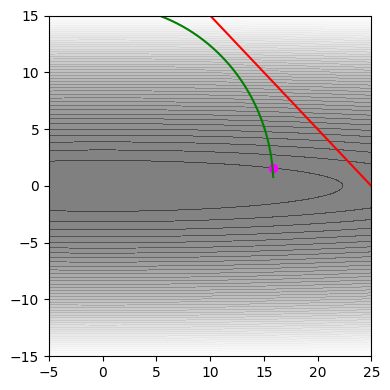

In [6]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


# BT12
# https://www.jstor.org/stable/2157674?seq=21, page 622
# It looks like this problem does not have a feasible solution, based on the projection
# below and the documented expected result.


def objective(y, args):
    x1, x2, *_ = y
    return 0.01 * x1**2 + x2**2


# def constraint(y):
#     x1, x2, x3, x4, x5 = y
#     c1 = x1 + x2 - x3**2 - 25  # x2 = 25 - x1 + x3**2
#     c2 = x1**2 + x2**2 - x4**2 - 25  # x2**2 = sqrt(25 + x4**2 - x1**2)
#     c3 = x1 - x5**2 - 2  # x1 = 2 + x5**2
#     return jnp.array([c1, c2, c3])


y0 = 2 * jnp.ones(5)
expected_result = jnp.array([15.811, 1.5811, 0, 15.083, 3.7164])

print(2 + 3.7164**2)

print(objective(y0, None), constraint(y0))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))


def _wrapped(y):
    return objective(y, None)


def c1_zero(x1):
    return 25 - x1  # - x3**2, but x3 = 0 at the solution


def c2_zero(x1):
    return jnp.sqrt(25 + 15.083**2 - x1**2)


x = jnp.linspace(-5, 25, 1000)
y = jnp.linspace(-15, 15, 1000)
X, Y = jnp.meshgrid(x, y)
Z = _wrapped((X, Y))
ax.contourf(X, Y, Z, levels=50, cmap="Grays_r", alpha=0.5)

ax.plot(x, c1_zero(x), color="red")
ax.plot(x, c2_zero(x), color="green")

ax.scatter(*expected_result[:2], color="magenta")

# Layout
ax.set_ylim(-15, 15)
fig.tight_layout()

In [7]:
# import equinox as eqx
# import jax.numpy as jnp


# class HATFLDH(eqx.Module):
#     """The HATFLDH problem from the CUTEST collection of benchmark problems.

#     A test problem from the OPTIMA user manual.
#     This is a nonlinear objective with linear constraints.

#     Source: "The OPTIMA user manual (issue No.8, p. 91)",
#     Numerical Optimization Centre, Hatfield Polytechnic (UK), 1989.

#     Classification: QLR2-AN-4-7
#     """

#     def objective(self, y, args):
#         x1, x2, x3, x4 = y
#         # From GROUP USES and ELEMENT TYPE sections:
#         # OBJ = -1.0 * A1 - 1.0 * A2
#         # A1 = X1 * X3, A2 = X2 * X4
#         return -1.0 * x1 * x3 - 1.0 * x2 * x4

#     def y0(self):
#         # From START POINT section
#         return jnp.array([1.0, 5.0, 5.0, 1.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2, x3, x4 = y
#         # From GROUPS, CONSTANTS, and RANGES sections:
#         # All constraints are inequality (G) with ranges
#         # C1: 2.5 <= X1 + X2 <= 7.5
#         # C2: 2.5 <= X1 + X3 <= 7.5
#         # C3: 2.5 <= X1 + X4 <= 7.5
#         # C4: 2.0 <= X2 + X3 <= 7.0
#         # C5: 2.0 <= X2 + X4 <= 7.0
#         # C6: 1.5 <= X3 + X4 <= 6.5
#         # C7: 5.0 <= X1 + X2 + X3 + X4 (no upper bound specified)

#         # For each constraint, we'll create two inequalities:
#         # lower_bound - value <= 0 and value - upper_bound <= 0

#         c1_lower = 2.5 - (x1 + x2)
#         c1_upper = (x1 + x2) - 7.5

#         c2_lower = 2.5 - (x1 + x3)
#         c2_upper = (x1 + x3) - 7.5

#         c3_lower = 2.5 - (x1 + x4)
#         c3_upper = (x1 + x4) - 7.5

#         c4_lower = 2.0 - (x2 + x3)
#         c4_upper = (x2 + x3) - 7.0

#         c5_lower = 2.0 - (x2 + x4)
#         c5_upper = (x2 + x4) - 7.0

#         c6_lower = 1.5 - (x3 + x4)
#         c6_upper = (x3 + x4) - 6.5

#         c7_lower = 5.0 - (x1 + x2 + x3 + x4)
#         # No upper bound for C7

#         # Combine all inequality constraints
#         inequalities = jnp.array([
#             c1_lower, c1_upper,
#             c2_lower, c2_upper,
#             c3_lower, c3_upper,
#             c4_lower, c4_upper,
#             c5_lower, c5_upper,
#             c6_lower, c6_upper,
#             c7_lower
#         ])

#         return None, inequalities

#     def bounds(self):
#         # From BOUNDS section: all variables have upper bound of 5.0
#         lower = jnp.zeros(4)  # Assuming lower bounds are 0.0 as not specified
#         upper = jnp.full(4, 5.0)
#         return lower, upper

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value
#         return -24.4999998

In [8]:
# import equinox as eqx
# import jax.numpy as jnp


# class HS12(eqx.Module):
#     """The HS12 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 12 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     Classification: QQR2-AN-2-1
#     """

#     def objective(self, y, args):
#         x1, x2 = y
#         # From GROUPS and GROUP USES sections:
#         # OBJ = -7.0*X1 - 7.0*X2 + 0.5*X1^2 + X2^2 - 1.0*X1*X2
#         return -7.0*x1 - 7.0*x2 + 0.5*x1**2 + x2**2 - 1.0*x1*x2

#     def y0(self):
#         # From START POINT section
#         return jnp.array([0.0, 0.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2 = y
#         # From GROUP USES and CONSTANTS sections:
#         # CON1 = -4.0*X1^2 - 1.0*X2^2 - 25.0 >= 0
#         # Rewritten as: -4.0*X1^2 - 1.0*X2^2 - 25.0 >= 0
#         con1 = -4.0*x1**2 - 1.0*x2**2 - 25.0
#         return jnp.array(0), jnp.array([con1])  # TODO hotfix trivial equality const

#     def bounds(self):
#         # From BOUNDS section: all variables are free (FR)
#         return None

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value
#         return -30.0


# solver = optx.IPOPTLike(rtol=1e-3, atol=1e-6)
# descent = optx.XDYcYdDescent()
# solver = eqx.tree_at(lambda s: s.descent, solver, descent)

# problem = HS12()

# solution = optx.minimise(
#     problem.objective,
#     solver,
#     problem.y0(),
#     constraint=problem.constraint,
#     bounds=problem.bounds(),
#     args=problem.args(),
#     max_steps=10,
#     throw=False,
# )

# solution.value, problem.objective(solution.value, None)

In [9]:
# import equinox as eqx
# import jax.numpy as jnp


# class HS13(eqx.Module):
#     """The HS13 problem from the CUTEST collection of benchmark problems.

#     A problem in 2 variables where constraint qualification does not hold.

#     Source: Problem 13 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     Classification: QOR2-AN-2-1
#     """

#     def objective(self, y, args):
#         x1, x2 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = E1 + E2 = (X1 - 2.0)^2 + X2^2
#         return (x1 - 2.0)**2 + x2**2

#     def y0(self):
#         # From START POINT section
#         return jnp.array([-2.0, -2.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2 = y
#         # From GROUPS, GROUP USES, and ELEMENT USES sections:
#         # CON1 = X2 - 1.0 + E3 >= 0
#         # E3 = CUBE(X1) = (1 - X1)^3
#         # So CON1 = X2 - 1.0 + (1 - X1)^3 >= 0
#         con1 = x2 - 1.0 + (1.0 - x1)**3
#         return None, jnp.array([con1])

#     def bounds(self):
#         # No explicit bounds are mentioned, so assuming variables are free
#         return None

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value
#         return 1.0

In [10]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS21(eqx.Module):
#     """The HS21 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 21 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: A.R. Conn, April 1990

#     Classification: QLR2-AN-2-1
#     """
#     def objective(self, y, args):
#         x1, x2 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = 0.01*E1 + E2
#         # E1 = SQ(V1) = x1^2 where V1 = x1
#         # E2 = SQ(V1) = x2^2 where V1 = x2
#         # Therefore, OBJ = 0.01*x1^2 + x2^2
#         # Also note the CONSTANTS section indicates HS21 OBJ 100.0, which appears to
#         # be a scale factor
#         return 100.0 * (0.01 * x1**2 + x2**2)

#     def y0(self):
#         # From START POINT section
#         return jnp.array([-1.0, -1.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2 = y
#         # From GROUPS section:
#         # CON1 = 10.0*X1 - 1.0*X2
#         # From CONSTANTS section:
#         # HS21 CON1 10.0 (appears to be a constant added to the constraint)
#         con1 = 10.0 * x1 - 1.0 * x2 + 10.0
#         return None, jnp.array([con1])

#     def bounds(self):
#         # From BOUNDS section:
#         # 2.0 ≤ X1 ≤ 50.0
#         # -50.0 ≤ X2 ≤ 50.0
#         lower = jnp.array([2.0, -50.0])
#         upper = jnp.array([50.0, 50.0])
#         return lower, upper

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return -99.96

In [11]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS22(eqx.Module):
#     """The HS22 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 22 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: A.R. Conn, April 1990

#     Classification: QQR2-AN-2-2
#     """
#     def objective(self, y, args):
#         x1, x2 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = E1 + E2
#         # E1 = SQ-2(V1) where V1 = x1, and SQ-2 means (V1-2)^2
#         # E2 = SQ-1(V1) where V1 = x2, and SQ-1 means (V1-1)^2
#         # Therefore, OBJ = (x1-2)^2 + (x2-1)^2
#         return (x1 - 2.0)**2 + (x2 - 1.0)**2

#     def y0(self):
#         # From START POINT section
#         return jnp.array([2.0, 2.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2 = y
#         # From GROUPS section:
#         # CON1 = -1.0*X1 - 1.0*X2
#         # From CONSTANTS section:
#         # HS22 CON1 -2.0 (constant added to the constraint)
#         con1 = -1.0 * x1 - 1.0 * x2 - 2.0

#         # From GROUPS and GROUP USES sections:
#         # CON2 = 1.0*X2 - 1.0*E3
#         # E3 = SQ(V1) = x1^2 where V1 = x1
#         con2 = 1.0 * x2 - 1.0 * x1**2

#         # Both constraints are marked with 'G' prefix in GROUPS section,
#         # indicating they are of the form: constraint >= 0
#         return None, jnp.array([con1, con2])

#     def bounds(self):
#         # From BOUNDS section:
#         # FR HS22 'DEFAULT' indicates free variables (no bounds)
#         return None

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return 1.0

In [12]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS23(eqx.Module):
#     """The HS23 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 23 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: A.R. Conn, April 1990

#     Classification: QQR2-AN-2-5
#     """
#     def objective(self, y, args):
#         x1, x2 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = E1 + E2
#         # E1 = SQ(V1) = x1^2 where V1 = x1
#         # E2 = SQ(V1) = x2^2 where V1 = x2
#         # Therefore, OBJ = x1^2 + x2^2
#         return x1**2 + x2**2

#     def y0(self):
#         # From START POINT section
#         return jnp.array([3.0, 1.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2 = y
#         # From GROUPS section and CONSTANTS section:
#         # CON1 = 1.0*X1 + 1.0*X2 + 1.0 (constant from CONSTANTS section)
#         con1 = 1.0 * x1 + 1.0 * x2 + 1.0

#         # From GROUP USES section:
#         # CON2 = E1 + E2 + 1.0 (constant from CONSTANTS section)
#         # = x1^2 + x2^2 + 1.0
#         con2 = x1**2 + x2**2 + 1.0

#         # From GROUP USES section:
#         # CON3 = 9.0*E1 + E2 + 9.0 (constant from CONSTANTS section)
#         # = 9.0*x1^2 + x2^2 + 9.0
#         con3 = 9.0 * x1**2 + x2**2 + 9.0

#         # From GROUPS and GROUP USES sections:
#         # CON4 = -1.0*X2 + E1 = -1.0*X2 + x1^2
#         con4 = -1.0 * x2 + x1**2

#         # From GROUPS and GROUP USES sections:
#         # CON5 = -1.0*X1 + E2 = -1.0*X1 + x2^2
#         con5 = -1.0 * x1 + x2**2

#         # All constraints are marked with 'G' prefix in GROUPS section,
#         # indicating they are of the form: constraint >= 0
#         return None, jnp.array([con1, con2, con3, con4, con5])

#     def bounds(self):
#         # From BOUNDS section:
#         # XL HS23 'DEFAULT' -50.0
#         # XU HS23 'DEFAULT' 50.0
#         lower = jnp.array([-50.0, -50.0])
#         upper = jnp.array([50.0, 50.0])
#         return lower, upper

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return 2.0

In [13]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS30(eqx.Module):
#     """The HS30 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 30 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: A.R. Conn, April 1990

#     Classification: QQR2-AN-3-1
#     """
#     def objective(self, y, args):
#         x1, x2, x3 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = E1 + E2 + E3
#         # E1 = SQ(V1) = x1^2 where V1 = x1
#         # E2 = SQ(V1) = x2^2 where V1 = x2
#         # E3 = SQ(V1) = x3^2 where V1 = x3
#         # Therefore, OBJ = x1^2 + x2^2 + x3^2
#         return x1**2 + x2**2 + x3**2

#     def y0(self):
#         # From START POINT section
#         # XV HS30 'DEFAULT' 1.0 - sets all variables to 1.0
#         return jnp.array([1.0, 1.0, 1.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2, x3 = y
#         # From GROUP USES and CONSTANTS sections:
#         # CON1 = E1 + E2 + 1.0 (constant from CONSTANTS section)
#         # = x1^2 + x2^2 + 1.0
#         con1 = x1**2 + x2**2 + 1.0

#         # The constraint is marked with 'G' prefix in GROUPS section,
#         # indicating it is of the form: constraint >= 0
#         return None, jnp.array([con1])

#     def bounds(self):
#         # From BOUNDS section:
#         # XL HS30 'DEFAULT' -10.0 (lower bound for all variables)
#         # XU HS30 'DEFAULT' 10.0 (upper bound for all variables)
#         # LO HS30 X1 1.0 (specific lower bound for X1)
#         lower = jnp.array([1.0, -10.0, -10.0])  # X1 has special lower bound
#         upper = jnp.array([10.0, 10.0, 10.0])
#         return lower, upper

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return 1.0

In [14]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS31(eqx.Module):
#     """The HS31 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 31 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: N. Gould, Dec 1989.

#     Classification: QQR2-AN-3-1
#     """
#     def objective(self, y, args):
#         x1, x2, x3 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = 9.0*OBJE1 + OBJE2 + 9.0*OBJE3
#         # OBJE(I) = SQ(V1) = X(I)^2 where V1 = X(I) for I=1,2,3
#         # Therefore, OBJ = 9.0*x1^2 + x2^2 + 9.0*x3^2
#         return 9.0 * x1**2 + x2**2 + 9.0 * x3**2

#     def y0(self):
#         # From START POINT section
#         # XV START 'DEFAULT' 1.0 - sets all variables to 1.0
#         return jnp.array([1.0, 1.0, 1.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2, x3 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # CONSTR = CONSTR1 + 1.0 (constant from CONSTANTS section)
#         # CONSTR1 = 2PR(V1,V2) = V1*V2 where V1 = x1, V2 = x2
#         # Therefore, CONSTR = x1*x2 + 1.0
#         con1 = x1 * x2 + 1.0

#         # The constraint is marked with 'G' prefix in GROUPS section,
#         # indicating it is of the form: constraint >= 0
#         return None, jnp.array([con1])

#     def bounds(self):
#         # From BOUNDS section:
#         # LO BOUNDS X1 -10.0
#         # LO BOUNDS X2 1.0
#         # LO BOUNDS X3 -10.0
#         # UP BOUNDS X1 10.0
#         # UP BOUNDS X2 10.0
#         # UP BOUNDS X3 1.0
#         lower = jnp.array([-10.0, 1.0, -10.0])
#         upper = jnp.array([10.0, 10.0, 1.0])
#         return lower, upper

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return 6.0

In [ ]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS35MOD(eqx.Module):
#     """The HS35MOD problem from the CUTEST collection of benchmark problems.

#     A modified version of Problem 35 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: A.R. Conn, April 1990

#     Classification: QLR2-AN-3-1
#     """
#     def objective(self, y, args):
#         x1, x2, x3 = y
#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ = 2.0*E1 + 2.0*E2 + 1.0*E3 + 2.0*E4 + 2.0*E5
#         # E1 = SQ(V1) = x1^2 where V1 = x1
#         # E2 = SQ(V1) = x2^2 where V1 = x2
#         # E3 = SQ(V1) = x3^2 where V1 = x3
#         # E4 = 2PR(V1,V2) = V1*V2 where V1 = x1, V2 = x2
#         # E5 = 2PR(V1,V2) = V1*V2 where V1 = x1, V2 = x3

#         # Also, from GROUPS section:
#         # OBJ += -8.0*X1 - 6.0*X2 - 4.0*X3

#         # And from CONSTANTS section:
#         # OBJ += -9.0

#         # Therefore:
#         # OBJ = 2.0*x1^2 + 2.0*x2^2 + 1.0*x3^2 + 2.0*x1*x2 + 2.0*x1*x3
#         #       - 8.0*x1 - 6.0*x2 - 4.0*x3 - 9.0

#         return (2.0 * x1**2 + 2.0 * x2**2 + 1.0 * x3**2 +
#                 2.0 * x1 * x2 + 2.0 * x1 * x3 -
#                 8.0 * x1 - 6.0 * x2 - 4.0 * x3 - 9.0)

#     def y0(self):
#         # From START POINT section
#         # XV HS35MOD 'DEFAULT' 0.5 - sets all variables to 0.5
#         return jnp.array([0.5, 0.5, 0.5])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2, x3 = y
#         # From GROUPS section:
#         # CON1 = -1.0*X1 - 1.0*X2 - 2.0*X3

#         # From CONSTANTS section:
#         # CON1 += -3.0

#         # Therefore:
#         # CON1 = -1.0*x1 - 1.0*x2 - 2.0*x3 - 3.0
#         con1 = -1.0 * x1 - 1.0 * x2 - 2.0 * x3 - 3.0

#         # The constraint is marked with 'G' prefix in GROUPS section,
#         # indicating it is of the form: constraint >= 0
#         return None, jnp.array([con1])

#     def bounds(self):
#         # From BOUNDS section:
#         # FX HS35MOD X2 0.5
#         # This indicates X2 is fixed at 0.5 (both lower and upper bounds are 0.5)
#         # X1 and X3 don't have explicit bounds
#         lower = jnp.array([-jnp.inf, 0.5, -jnp.inf])
#         upper = jnp.array([jnp.inf, 0.5, jnp.inf])
#         return lower, upper

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return 0.1111111111

In [ ]:
# IMPORTANT Link: contains options for Julia CUTEST interface, which are enumerated
# *literally* nowhere else.
# https://jso.dev/CUTEst.jl/v0.8/tutorial/

In [ ]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS113(eqx.Module):
#     """The HS113 problem from the CUTEST collection of benchmark problems.

#     Source: Problem 80 in W. Hock and K. Schittkowski,
#     "Test examples for nonlinear programming codes",
#     Lectures Notes in Economics and Mathematical Systems 187,
#     Springer Verlag, Heidelberg, 1981.

#     SIF input: J-M Collin, Mar 1990.

#     Classification: QQR2-AN-10-8
#     """
#     def objective(self, y, args):
#         x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = y

#         # From GROUP USES and ELEMENT USES sections:
#         # OBJ includes OE1, OE2, ..., OE11 which are:
#         # OE1 = SQ(X) = x1^2 where X = x1
#         # OE2 = SQ(X) = x2^2 where X = x2
#         # ...
#         # OE10 = SQ(X) = x10^2 where X = x10
#         # OE11 = 2PR(X,Y) = X*Y where X = x1, Y = x2

#         # With their coefficients from GROUP USES section:
#         # OBJ = OE1 + OE2 + OE3 + 4.0*OE4 + OE5 + 2.0*OE6 + 5.0*OE7 +
#           7.0*OE8 + 2.0*OE9 + OE10 + OE11

#         # Also linear terms from GROUPS section:
#         # OBJ += -14.0*X1 - 16.0*X2 - 20.0*X3 - 40.0*X4 - 6.0*X5 - 4.0*X6 - 154.0*X8
#           - 40.0*X9 - 14.0*X10
#         # (note X7 doesn't have a linear term)

#         # And from CONSTANTS section:
#         # OBJ += -1352.0

#         # Therefore:
#         obj_quad = (x1**2 + x2**2 + x3**2 + 4.0*x4**2 + x5**2 + 2.0*x6**2 +
#                    5.0*x7**2 + 7.0*x8**2 + 2.0*x9**2 + x10**2 + x1*x2)

#         obj_lin = (-14.0*x1 - 16.0*x2 - 20.0*x3 - 40.0*x4 - 6.0*x5 -
#                   4.0*x6 - 154.0*x8 - 40.0*x9 - 14.0*x10)

#         obj_const = -1352.0

#         return obj_quad + obj_lin + obj_const

#     def y0(self):
#         # From START POINT section
#         return jnp.array([2.0, 3.0, 5.0, 5.0, 1.0, 2.0, 7.0, 3.0, 6.0, 10.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = y

#         # From GROUPS section and CONSTANTS section:
#         # C1 = -4.0*X1 - 5.0*X2 + 3.0*X7 - 9.0*X8 - 105.0
#         c1 = -4.0*x1 - 5.0*x2 + 3.0*x7 - 9.0*x8 - 105.0

#         # C2 = -10.0*X1 + 8.0*X2 + 17.0*X7 - 2.0*X8
#         # (no constant term for C2)
#         c2 = -10.0*x1 + 8.0*x2 + 17.0*x7 - 2.0*x8

#         # C3 = 8.0*X1 - 2.0*X2 - 5.0*X9 + 2.0*X10 - 12.0
#         c3 = 8.0*x1 - 2.0*x2 - 5.0*x9 + 2.0*x10 - 12.0

#         # From GROUPS, GROUP USES, and CONSTANTS sections:
#         # C4 = 12.0*X1 + 24.0*X2 + 7.0*X4 - 3.0*CE1 - 4.0*CE2 - 2.0*CE3 - 72.0
#         # Where CE1 = SQ(X) = x1^2, CE2 = SQ(X) = x2^2, CE3 = SQ(X) = x3^2
#         c4 = 12.0*x1 + 24.0*x2 + 7.0*x4 - 3.0*x1**2 - 4.0*x2**2 - 2.0*x3**2 - 72.0

#         # C5 = -8.0*X2 + 12.0*X3 + 2.0*X4 - 5.0*CE4 - 1.0*CE5 - 4.0
#         # Where CE4 = SQ(X) = x1^2, CE5 = SQ(X) = x3^2
#         c5 = -8.0*x2 + 12.0*x3 + 2.0*x4 - 5.0*x1**2 - 1.0*x3**2 - 4.0

#         # C6 = 8.0*X1 + 16.0*X2 + 1.0*X6 - 0.5*CE6 - 2.0*CE7 - 3.0*CE8 + 34.0
#         # Where CE6 = SQ(X) = x1^2, CE7 = SQ(X) = x2^2, CE8 = SQ(X) = x5^2
#         c6 = 8.0*x1 + 16.0*x2 + 1.0*x6 - 0.5*x1**2 - 2.0*x2**2 - 3.0*x5**2 + 34.0

#         # C7 = 8.0*X2 - 14.0*X5 + 6.0*X6 - 1.0*CE9 - 2.0*CE10 + 2.0*CE11 + 8.0
#         # Where CE9 = SQ(X) = x1^2, CE10 = SQ(X) = x2^2, CE11 = 2PR(X,Y) = x1*x2
#         c7 = 8.0*x2 - 14.0*x5 + 6.0*x6 - 1.0*x1**2 - 2.0*x2**2 + 2.0*x1*x2 + 8.0

#         # C8 = 3.0*X1 - 6.0*X2 + 192.0*X9 + 7.0*X10 - 12.0*CE12 + 768.0
#         # Where CE12 = SQ(X) = x9^2
#         c8 = 3.0*x1 - 6.0*x2 + 192.0*x9 + 7.0*x10 - 12.0*x9**2 + 768.0

#         # All constraints are marked with 'G' prefix in GROUPS section,
#         # indicating they are of the form: constraint >= 0
#         return None, jnp.array([c1, c2, c3, c4, c5, c6, c7, c8])

#     def bounds(self):
#         # From BOUNDS section:
#         # FR HS113 'DEFAULT' indicates free variables (no bounds)
#         return None

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # From OBJECT BOUND section, LO SOLTN value (commented out)
#         return 24.3062091

In [ ]:
# import equinox as eqx
# import jax.numpy as jnp

# class HS268(eqx.Module):
#     """The HS268 problem from the CUTEST collection of benchmark problems.

#     A quadratic programming problem.

#     Source: K. Schittkowski,
#     "More Test Examples for Nonlinear Programming Codes",
#     Springer Verlag, Berlin, Lecture notes in economics and
#     mathematical systems, volume 282, 1987

#     SIF input: Michel Bierlaire and Annick Sartenaer, October 1992.
#                 minor correction by Ph. Shott, Jan 1995.

#     Classification: QLR2-AN-5-5
#     """
#     def objective(self, y, args):
#         x1, x2, x3, x4, x5 = y

#         # The objective has a quadratic part (NONL) and a linear part (LINEAR)

#         # From the D matrices defined at the top, we can construct the quadratic term
#         # The elements D(i,j) define the coefficients of the quadratic terms
#         D = jnp.array([
#             [10197.0, -12454.0, -1013.0, 1948.0, 329.0],
#             [-12454.0, 20909.0, -1733.0, -4914.0, -186.0],
#             [-1013.0, -1733.0, 1755.0, 1089.0, -174.0],
#             [1948.0, -4914.0, 1089.0, 1515.0, -22.0],
#             [329.0, -186.0, -174.0, -22.0, 27.0]
#         ])

#         # The linear coefficients are B(i)
#         B = jnp.array([-9170.0, 17099.0, -2271.0, -4336.0, -43.0])

#         # The constant term is defined in CONSTANTS section: HS268 NONL -14463.0
#         C = -14463.0

#         # From GROUPS and GROUP USES sections:
#         # The objective function is 0.5*x^T*D*x + B^T*x + C
#         # Note the -0.5 scale factor in the LINEAR group

#         # Compute x^T*D*x
#         quad_term = 0.0
#         for i in range(5):
#             for j in range(5):
#                 quad_term += y[i] * D[i, j] * y[j]

#         # Compute B^T*x
#         linear_term = jnp.sum(B * y)

#         # Apply the -0.5 scale factor to the linear term
#         linear_term *= -0.5

#         return quad_term + linear_term + C

#     def y0(self):
#         # From START POINT section
#         # V HS268 'DEFAULT' 1.0 - sets all variables to 1.0
#         return jnp.array([1.0, 1.0, 1.0, 1.0, 1.0])

#     def args(self):
#         return None

#     def constraint(self, y):
#         x1, x2, x3, x4, x5 = y

#         # From GROUPS section and CONSTANTS section:
#         # C1 = -1.0*X1 - 1.0*X2 - 1.0*X3 - 1.0*X4 - 1.0*X5 - 5.0
#         c1 = -1.0*x1 - 1.0*x2 - 1.0*x3 - 1.0*x4 - 1.0*x5 - 5.0

#         # C2 = 10.0*X1 + 10.0*X2 - 3.0*X3 + 5.0*X4 + 4.0*X5 + 20.0
#         c2 = 10.0*x1 + 10.0*x2 - 3.0*x3 + 5.0*x4 + 4.0*x5 + 20.0

#         # C3 = -8.0*X1 + 1.0*X2 - 2.0*X3 - 5.0*X4 + 3.0*X5 - 40.0
#         c3 = -8.0*x1 + 1.0*x2 - 2.0*x3 - 5.0*x4 + 3.0*x5 - 40.0

#         # C4 = 8.0*X1 - 1.0*X2 + 2.0*X3 + 5.0*X4 - 3.0*X5 + 11.0
#         c4 = 8.0*x1 - 1.0*x2 + 2.0*x3 + 5.0*x4 - 3.0*x5 + 11.0

#         # C5 = -4.0*X1 - 2.0*X2 + 3.0*X3 - 5.0*X4 + 1.0*X5 - 30.0
#         c5 = -4.0*x1 - 2.0*x2 + 3.0*x3 - 5.0*x4 + 1.0*x5 - 30.0

#         # All constraints are marked with 'XG' prefix in GROUPS section,
#         # which appears to be a variant indicating they are of the form:
#         # constraint >= 0
#         return None, jnp.array([c1, c2, c3, c4, c5])

#     def bounds(self):
#         # From BOUNDS section:
#         # XR HS268 'DEFAULT' indicates variables are real (not bounded)
#         return None

#     def expected_result(self):
#         # The optimal point coordinates are not provided
#         return None

#     def expected_objective_value(self):
#         # Not explicitly provided in the SIF file
#         return None